<a href="https://colab.research.google.com/github/AhmedB479/Pest-Prediction/blob/main/Copy_of_FYP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("Crop.csv")

# Encode categorical columns
le_label = LabelEncoder()
le_district = LabelEncoder()
df['label_encoded'] = le_label.fit_transform(df['label'])
df['district_encoded'] = le_district.fit_transform(df['district'])

# Drop original label and district columns
df.drop(columns=['label', 'district'], inplace=True)

# Add synthetic 'pest' column based on humidity and temperature
df['pest'] = ((df['humidity'] > 80) & (df['temperature'] > 25)).astype(int)

# Add Growing Degree Day (GDD)
T_base = 10  # base temperature
df['GDD'] = (df['temperature'] - T_base).apply(lambda x: max(0, x))

# Save to new CSV
df.to_csv("processed_crop.csv", index=False)
print("✅ File saved as processed_crop.csv")


✅ File saved as processed_crop.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score


In [ ]:
# Load the processed dataset
df = pd.read_csv("processed_crop.csv")
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label_encoded,district_encoded,pest,GDD
0,90,42,43,20.879744,82.002744,6.502985,202.935536,10,32,0,10.879744
1,85,58,41,21.770462,80.319644,7.038096,226.655537,10,1,0,11.770462
2,60,55,44,23.004459,82.320763,7.840207,263.964248,10,3,0,13.004459
3,74,35,40,26.491096,80.158363,6.980401,242.864034,10,30,1,16.491096
4,78,42,42,20.130175,81.604873,7.628473,262.717340,10,7,0,10.130175


In [ ]:
# Separate features and target
X = df.drop(columns=["pest"])
y = df["pest"]

# Feature names
feature_names = X.columns.tolist()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_scaled, y_train)
scores = selector.scores_

# Create DataFrame of feature scores
feature_scores = pd.DataFrame({"Feature": feature_names, "Score": scores})
feature_scores.sort_values(by="Score", ascending=False, inplace=True)
feature_scores


,Feature,Score
4,humidity,520.396623
9,GDD,365.958987
3,temperature,365.553943
1,P,62.063079
0,N,35.983631
7,label_encoded,25.249350
5,ph,6.523372
6,rainfall,6.180696
8,district_encoded,1.029299
2,K,0.568810


In [ ]:
# Select top features (e.g., top 5)
top_features = feature_scores["Feature"].head(5).tolist()

X_train_fs = X_train_scaled[:, selector.get_support()]
X_test_fs = X_test_scaled[:, selector.get_support()]


In [ ]:
nb_fs = GaussianNB()
nb_fs.fit(X_train_fs, y_train)
y_pred_nb_fs = nb_fs.predict(X_test_fs)
y_prob_nb_fs = nb_fs.predict_proba(X_test_fs)[:, 1]

print("Naive Bayes with Feature Selection")
print(classification_report(y_test, y_pred_nb_fs))
print("ROC AUC:", roc_auc_score(y_test, y_prob_nb_fs))


Naive Bayes with Feature Selection
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       469
           1       0.81      0.95      0.88       191

    accuracy                           0.92       660
   macro avg       0.90      0.93      0.91       660
weighted avg       0.93      0.92      0.92       660

ROC AUC: 0.9848513602518448


In [ ]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
y_prob_nb = nb.predict_proba(X_test_scaled)[:, 1]

print("Naive Bayes without Feature Selection")
print(classification_report(y_test, y_pred_nb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_nb))


Naive Bayes without Feature Selection
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       469
           1       0.81      0.95      0.88       191

    accuracy                           0.92       660
   macro avg       0.90      0.93      0.91       660
weighted avg       0.93      0.92      0.92       660

ROC AUC: 0.9848513602518448


In [ ]:
adb_fs = AdaBoostClassifier(n_estimators=100, random_state=42)
adb_fs.fit(X_train_fs, y_train)
y_pred_adb_fs = adb_fs.predict(X_test_fs)
y_prob_adb_fs = adb_fs.predict_proba(X_test_fs)[:, 1]

print("AdaBoost with Feature Selection")
print(classification_report(y_test, y_pred_adb_fs))
print("ROC AUC:", roc_auc_score(y_test, y_prob_adb_fs))


AdaBoost with Feature Selection
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       469
           1       1.00      1.00      1.00       191

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660

ROC AUC: 1.0


In [ ]:
adb = AdaBoostClassifier(n_estimators=100, random_state=42)
adb.fit(X_train_scaled, y_train)
y_pred_adb = adb.predict(X_test_scaled)
y_prob_adb = adb.predict_proba(X_test_scaled)[:, 1]

print("AdaBoost without Feature Selection")
print(classification_report(y_test, y_pred_adb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_adb))


AdaBoost without Feature Selection
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       469
           1       1.00      1.00      1.00       191

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660

ROC AUC: 1.0


In [ ]:
pip install gradio pandas scikit-learn


In [25]:
import pandas as pd
import numpy as np
import gradio as gr
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

# Load data
df = pd.read_csv("processed_crop.csv")

# Get the feature names from training data
feature_columns = df.drop(columns=["pest"]).columns.tolist()

# Setup encoders for dropdowns
label_encoder = LabelEncoder()
district_encoder = LabelEncoder()

# Recreate label mappings
original_df = pd.read_csv("Crop.csv")
label_encoder.fit(original_df["label"])
district_encoder.fit(original_df["district"])

# Prepare data
X = df.drop(columns=["pest"])
y = df["pest"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train models
nb_model = GaussianNB()
nb_model.fit(X_scaled, y)

adb_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adb_model.fit(X_scaled, y)

# Prediction function
def predict_pest(temp, hum, ph, rainfall, label, district, nitrogen, phosphorus, potassium):
    # Calculate GDD
    gdd = max(0, temp - 10)

    # Encode categorical features
    label_encoded = label_encoder.transform([label])[0]
    district_encoded = district_encoder.transform([district])[0]

    # Create base features dictionary with correct feature names
    input_dict = {
        'N': nitrogen,
        'P': phosphorus,
        'K': potassium,
        'temperature': temp,
        'humidity': hum,
        'ph': ph,
        'rainfall': rainfall,
        'GDD': gdd,  # Note: Using uppercase GDD to match training data
        'label_encoded': label_encoded,
        'district_encoded': district_encoded
    }

    # Create a DataFrame with all feature columns (initialize to 0)
    input_df = pd.DataFrame(columns=feature_columns)
    input_df = pd.concat([input_df, pd.DataFrame([input_dict])], ignore_index=True).fillna(0)

    # Scale the input
    input_scaled = scaler.transform(input_df)

    # Get predictions
    nb_pred = nb_model.predict(input_scaled)[0]
    nb_prob = nb_model.predict_proba(input_scaled)[0][1]

    adb_pred = adb_model.predict(input_scaled)[0]
    adb_prob = adb_model.predict_proba(input_scaled)[0][1]

    return (
        "🌿 Pest" if nb_pred == 1 else "✅ No Pest",
        round(nb_prob, 3),
        "🌿 Pest" if adb_pred == 1 else "✅ No Pest",
        round(adb_prob, 3),
        round(gdd, 3)
    )

# Gradio UI
iface = gr.Interface(
    fn=predict_pest,
    inputs=[
        gr.Number(label="Temperature (°C)", value=25.0),
        gr.Number(label="Humidity (%)", value=60.0),
        gr.Number(label="pH Level", value=7.0),
        gr.Number(label="Rainfall (mm)", value=100.0),
        gr.Dropdown(label_encoder.classes_.tolist(), label="Crop Label"),
        gr.Dropdown(district_encoder.classes_.tolist(), label="District"),
        gr.Number(label="Nitrogen (kg/ha)", value=50.0),
        gr.Number(label="Phosphorus (kg/ha)", value=50.0),
        gr.Number(label="Potassium (kg/ha)", value=50.0)
    ],
    outputs=[
        gr.Text(label="Naive Bayes Prediction"),
        gr.Number(label="Naive Bayes Probability"),
        gr.Text(label="AdaBoost Prediction"),
        gr.Number(label="AdaBoost Probability"),
        gr.Number(label="GDD (Growing Degree Days)")
    ],
    title="🌾 Cotton Pest Prediction Dashboard",
    description="Enter crop conditions to predict the likelihood of pest infestation using machine learning models.",
    theme=gr.themes.Soft()
)

if __name__ == "__main__":
    iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f9c471993a8c60dfce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-25-3316100381>:63: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-25-3316100381>:63: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Created dataset file at: .gradio/flagged/dataset1.csv


<ipython-input-25-3316100381>:63: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f9c471993a8c60dfce.gradio.live


In [ ]:
pip install scikit-learn pandas numpy


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

# Load your data
df = pd.read_csv("processed_crop.csv")
X = df.drop(columns=["pest"])
y = df["pest"]
feature_names = X.columns.tolist()

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)
y_prob = nb.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("✅ Accuracy:", accuracy)
print("✅ F1 Score:", f1)
print("✅ AUC-ROC:", auc)

# Permutation importance
results = permutation_importance(nb, X_test_scaled, y_test, n_repeats=30, random_state=42)
importances = results.importances_mean

# Display sorted features
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\n📊 Permutation Importance of Features:\n")
print(importance_df)


✅ Accuracy: 0.9227272727272727
✅ F1 Score: 0.8771084337349397
✅ AUC-ROC: 0.9848513602518448

📊 Permutation Importance of Features:

            Feature  Importance
4          humidity    0.220101
9               GDD    0.053838
3       temperature    0.053687
5                ph    0.005909
7     label_encoded    0.005253
6          rainfall    0.001667
8  district_encoded   -0.001212
2                 K   -0.001818
1                 P   -0.003333
0                 N   -0.011313


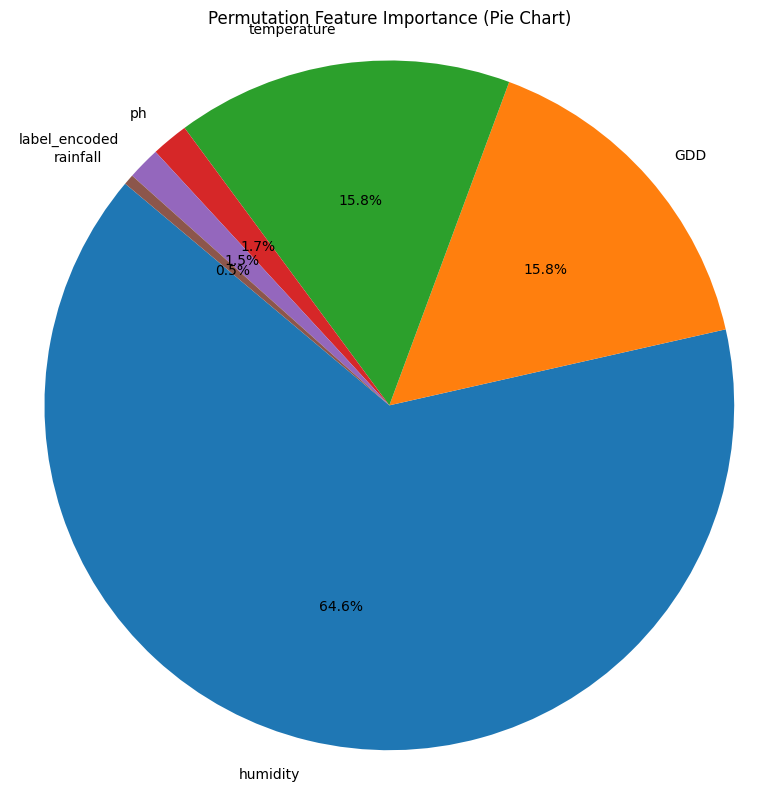

In [ ]:
import matplotlib.pyplot as plt

# Remove features with zero or negative importance (optional, for cleaner chart)
importance_df = importance_df[importance_df["Importance"] > 0]

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    importance_df["Importance"],
    labels=importance_df["Feature"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Permutation Feature Importance (Pie Chart)")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


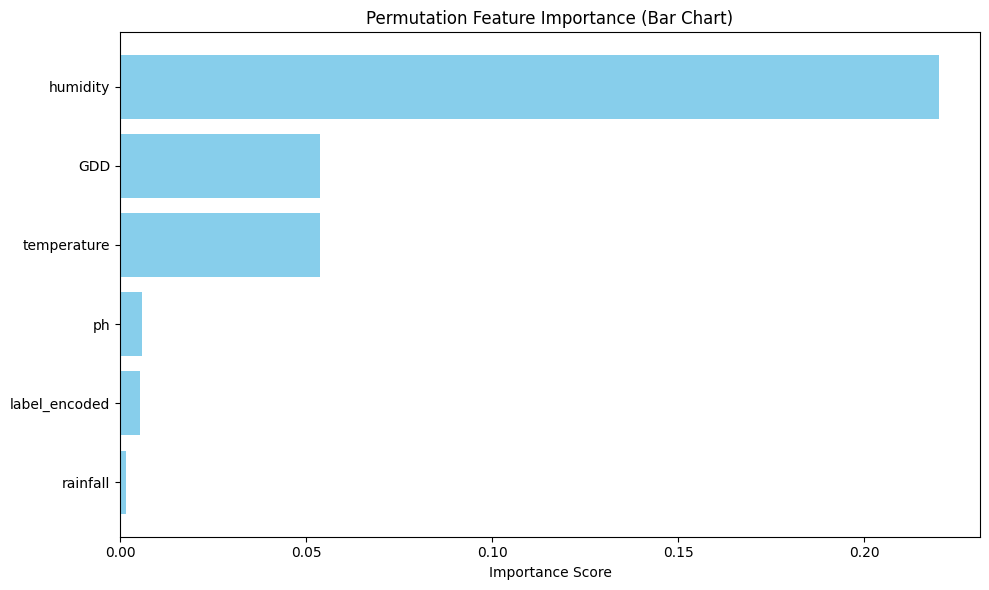

In [ ]:
# Bar chart
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance Score")
plt.title("Permutation Feature Importance (Bar Chart)")
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()


In [ ]:
pip install plotly


In [ ]:
import plotly.express as px

# Interactive bar chart
fig = px.bar(
    importance_df,
    x="Importance",
    y="Feature",
    orientation="h",
    title="🧠 Interactive Permutation Feature Importance",
    labels={"Importance": "Importance Score", "Feature": "Feature"},
    color="Importance",
    color_continuous_scale="Blues"
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


In [ ]:
!pip install pandas scikit-learn lime shap matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2b2c3f5ea3f94bcf7bef012786c2c9be6b9eb1cb51137bd3dd7b66731f7bb462
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


=== Decision Tree ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.91      1.00      0.95        20
           2       0.98      0.98      0.98        61
           3       1.00      1.00      1.00        14
           4       0.92      1.00      0.96        11
           5       0.98      0.98      0.98        57
           6       0.94      0.89      0.92        19
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        19
           9       1.00      0.96      0.98        26
          10       0.91      0.93      0.92        42
          11       0.93      0.91      0.92        70
          12       1.00      0.98      0.99        60

    accuracy                           0.97       440
   macro avg       0.97      0.97      0.97       440
weighted avg       0.97      0.97      0.97       440

=== Random Forest ===
              precision    recall  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Showing SHAP summary plot:
Showing SHAP summary plot:


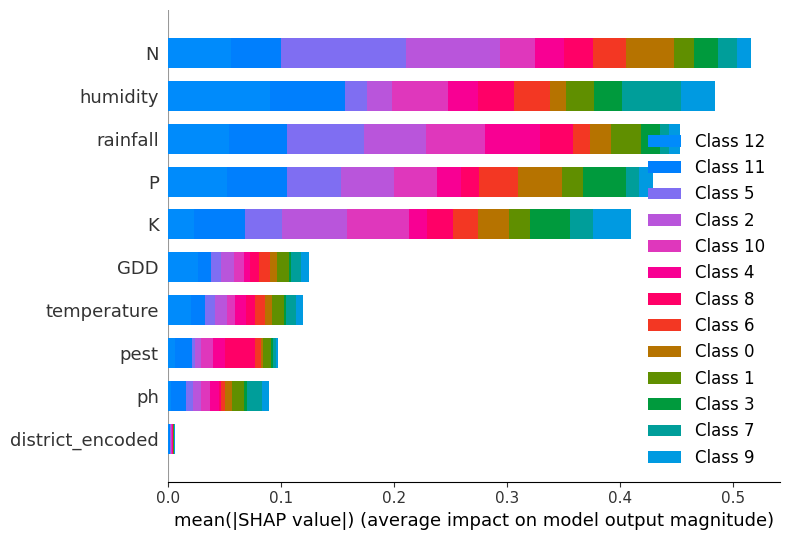

IndexError: index 5 is out of bounds for axis 0 with size 1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import lime
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv("processed_crop.csv")  # Adjust path if needed
X = df.drop(columns=["label_encoded"])
y = df["label_encoded"]

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Models

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
print("=== Decision Tree ===")
print(classification_report(y_test, dt_preds))

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("=== Random Forest ===")
print(classification_report(y_test, rf_preds))

# SVM with scaling
svm = make_pipeline(StandardScaler(), SVC(probability=True))
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("=== SVM ===")
print(classification_report(y_test, svm_preds))

# 4. LIME (for Random Forest)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=[str(c) for c in sorted(y.unique())],
    mode='classification'
)

print("Showing LIME explanation for 1 sample prediction:")
lime_exp = explainer.explain_instance(X_test.iloc[0].values, rf.predict_proba, num_features=6)
lime_exp.show_in_notebook(show_table=True)

# 5. SHAP (for Random Forest)
explainer_shap = shap.TreeExplainer(rf)
shap_values = explainer_shap.shap_values(X_train)

print("Showing SHAP summary plot:")
# 5. SHAP (for Random Forest)
explainer_shap = shap.TreeExplainer(rf)
shap_values = explainer_shap.shap_values(X_train)

print("Showing SHAP summary plot:")
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Show SHAP decision plot for 1 test sample
instance_idx = 0  # Use first test instance
test_instance = X_test.iloc[instance_idx:instance_idx+1]

# Compute SHAP values for this specific instance
test_shap_values = explainer_shap.shap_values(test_instance)

# Get predicted class for this instance
predicted_class = rf.predict(test_instance)[0]
class_idx = list(rf.classes_).index(predicted_class)

# Extract values for the predicted class
base_value = explainer_shap.expected_value[class_idx]
shap_val = test_shap_values[class_idx][0]  # Get first (and only) row
features_arr = test_instance.values[0]  # Convert to NumPy array

# Generate decision plot
shap.decision_plot(
    base_value,
    shap_val,
    features_arr,
    feature_names=X_test.columns.tolist()  # Optional: show feature names
)

In [ ]:
    explainer_shap.expected_value[0],
